# 3. 딥러닝 시계열 모델링
RNN 구성요소:
- 배치 크기
- 시간 단계
- 특징 수

In [3]:
!pip install tensorflow

   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
    --------------------------------------- 5.8/332.0 MB 28.3 MB/s eta 0:00:12
   - -------------------------------------- 12.6/332.0 MB 31.1 MB/s eta 0:00:11
   -- ------------------------------------- 20.7/332.0 MB 33.5 MB/s eta 0:00:10
   --- ------------------------------------ 28.8/332.0 MB 34.6 MB/s eta 0:00:09
   ---- ----------------------------------- 36.2/332.0 MB 34.4 MB/s eta 0:00:09
   ----- ---------------------------------- 45.6/332.0 MB 35.8 MB/s eta 0:00:08
   ------ --------------------------------- 53.5/332.0 MB 36.0 MB/s eta 0:00:08
   ------- -------------------------------- 61.6/332.0 MB 36.4 MB/s eta 0:00:08
   -------- ------------------------------- 68.2/332.0 MB 35.8 MB/s eta 0:00:08
   --------- ------------------------------ 75.8/332.0 MB 36.0 MB/s eta 0:00:08
   ---------- ----------------------------- 84.4/332.0 MB 36.6 MB/s eta 0:00:07
   ----------- ---------------------------- 92.5/3

In [1]:
import numpy as np
import pandas as pd
import math
import datetime
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

c:\Users\82103\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, MaxPooling2D, SimpleRNN)
from sklearn.model_selection import train_test_split

In [ ]:
n_steps=13 # 예측 단게의 수
n_features=1 # 특징의 수

In [ ]:
# 1. RNN 모델 구축
model=Sequential() # Layer를 순서대로 쌓아 올리겠다
# SimpleRNN(뉴런(은닉 노드 개수), 활성화 함수, (시간 범위, 각 시점 특성 개수), True: 매 시간 단계 출력~다음 층으로 시계열 정보 넘길 떄)
model.add(SimpleRNN(512, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2)) # 20% DropOut
model.add(Dense(256, activation='relu')) # Fully connected layer 생성(예측 개수)
model.add(Flatten())
# 선형 활성화함수로 출력 계층 추가
model.add(Dense(1,activation='linear')) # 예측값 1개, 선형 활성화 함수

c:\Users\82103\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# 2. 모델을 어떻게 학습시킬지
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mse'])

In [7]:
def split_sequence(sequence, n_steps):
    X, y=[], []
    for i in range(len(sequence)):
        end_ix=i+n_steps # 끝나는 인덱스
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y= sequence[i:end_ix],sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

(*) 활성화 함수
: 신경망 구조에서 출력을 결정하는 데 사용되는 수학식 
: 은닉층에 비선형성 도입해 비선형 문제 모델링함
1. 시그모이드: 0과 1 사이값 ~ 출력 통합
2. Tanh: -1과 1 사이값 ~ 음수 처리에 좋음 
3. 선형: 입력에 비례하는 출력 형성 ~ 독립, 종속 간 선형 관계 구성
4. 정류 선형: Relu ~ max(0,x)
5. 소프트맥스: 확률 분포로 변환 ~ 분류 문제

In [8]:
ticker=['AAPL','MSFT']
start=datetime.datetime(2019,1,1)
end=datetime.datetime(2020,1,1)
stock_prices=yf.download(ticker, start=start, end=end, interval='1d').Close

[*********************100%***********************]  2 of 2 completed


In [10]:
diff_stock_prices=stock_prices.diff().dropna() # 현재 행 - 이전 행 (첫 번째 행 = NaN)
split=int(len(diff_stock_prices['AAPL'].values)*0.95)
diff_train_aapl=diff_stock_prices['AAPL'].iloc[:split]
diff_test_aapl=diff_stock_prices['AAPL'].iloc[split:]
diff_train_msft=diff_stock_prices['MSFT'].iloc[:split]
diff_test_msft=diff_stock_prices['MSFT'].iloc[split:]

In [ ]:
X_aapl, y_aapl=split_sequence(diff_train_aapl, n_steps)
# reshape: 
# shape: array의 차원 반환
X_aapl=X_aapl.reshape((X_aapl.shape[0], X_aapl.shape[1], n_features))

C:\Users\82103\AppData\Local\Temp\ipykernel_7044\3210694584.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq_x, seq_y= sequence[i:end_ix],sequence[end_ix]


In [ ]:
# epoch 별 손실값, 정확도 등 저장
# 전체 데이터 400번 학습(훑기)
history=model.fit(X_aapl, y_aapl, epochs=400, batch_size=150, verbose=0, validation_split=0.10)

In [ ]:
# 마지막 예측할 input
start=X_aapl[X_aapl.shape[0]-n_steps]
x_input=start # ndarray(13,1)
x_input=x_input.reshape((1, n_steps, n_features)) # (1,13,1)

In [17]:
# 예측 저장할 빈 리스트
templist_aapl=[]
for i in range(len(diff_test_aapl)):
    x_input=x_input.reshape((1,n_steps,n_features)) #(1,13,1)
    yhat=model.predict(x_input,verbose=0)
    x_input=np.append(x_input, yhat)
    x_input=x_input[1:]
    templist_aapl.append(yhat)


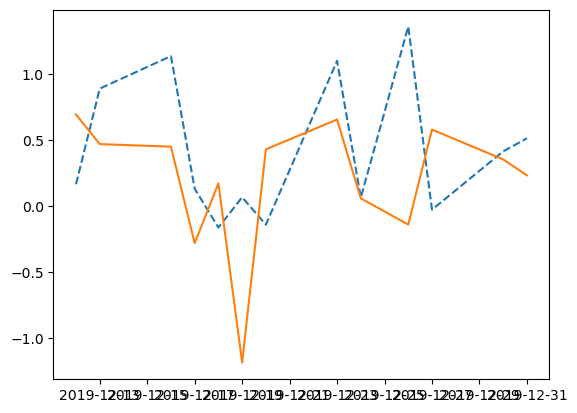

In [18]:
plt.plot(diff_test_aapl,label='Actual Stock Price', linestyle='--')
plt.plot(diff_test_aapl.index, np.array(templist_aapl).flatten(), linestyle='solid', label='best')

(*) RNN 단점:
- 소멸 or 폭발하는 그래디언트 문제
- 데이터 양이 많을 경우 훈련 어려움
- tanh 활성화함수 사용할 경우 RNN은 매우 긴 시퀀스 처리 불가

(*) LSTM
: 불필요한 정보 제거해 좀 더 효율적으로 작동하도록 함
- Forget gate
- Input gate
- Output gate
- 후보 기억 셀
- 기억 셀
- 은닉 상태

In [19]:
# LSTM
from tensorflow.keras.layers import LSTM

In [20]:
n_steps=13
n_features=1

In [23]:
model=Sequential()
model.add(LSTM(512, activation='relu',input_shape=(n_steps,n_features),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256,activation='relu'))
model.add(Flatten())
model.add(Dense(1,activation='linear'))

model.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mse'])

c:\Users\82103\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
history=model.fit(X_aapl, y_aapl, epochs=400, batch_size=150, verbose=0, validation_split=0.10)

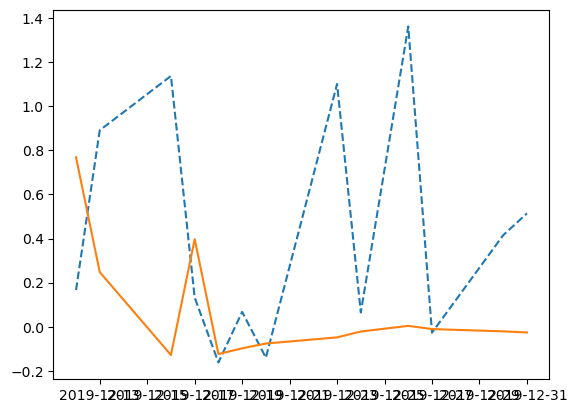

In [25]:
start=X_aapl[X_aapl.shape[0]-13]
x_input=start
x_input=x_input.reshape((1,n_steps,n_features))

templist_aapl=[]
for i in range(len(diff_test_aapl)):
    x_input=x_input.reshape((1,n_steps,n_features)) #(1,13,1)
    yhat=model.predict(x_input,verbose=0)
    x_input=np.append(x_input, yhat)
    x_input=x_input[1:]
    templist_aapl.append(yhat)

plt.plot(diff_test_aapl,label='Actual Stock Price', linestyle='--')
plt.plot(diff_test_aapl.index, np.array(templist_aapl).flatten(), linestyle='solid', label='best')